# Setup and General Data Overview

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
!nvidia-smi

Wed Jun 23 19:52:25 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    27W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
from psutil import virtual_memory
virtual_memory().total / 1e9

27.339640832

Special thanks to [watsonbox's exportify repo](https://github.com/watsonbox/exportify) which allowed me to pull all of these songs and their features down from Spotify.

In [4]:
import os.path

# raw_data = pd.read_csv('data/liked_labeled.csv') # local only
if os.path.isfile('liked_labeled.csv') == False:
  !wget https://raw.githubusercontent.com/nullmaxwell/learnify/main/data/liked_labeled.csv
else:
  print("Data already present!")
raw_data = pd.read_csv('liked_labeled.csv')

--2021-06-23 19:53:43--  https://raw.githubusercontent.com/nullmaxwell/learnify/main/data/liked_labeled.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2166386 (2.1M) [text/plain]
Saving to: ‘liked_labeled.csv’

liked_labeled.csv   100%[===================>]   2.07M  --.-KB/s    in 0.08s   

2021-06-23 19:53:44 (27.1 MB/s) - ‘liked_labeled.csv’ saved [2166386/2166386]



In [5]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4296 entries, 0 to 4295
Data columns (total 32 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Unnamed: 0            4296 non-null   int64  
 1   Track URI             4296 non-null   object 
 2   Track Name            4296 non-null   object 
 3   Artist URI(s)         4296 non-null   object 
 4   Artist Name(s)        4296 non-null   object 
 5   Album URI             4296 non-null   object 
 6   Album Name            4296 non-null   object 
 7   Album Artist URI(s)   4296 non-null   object 
 8   Album Artist Name(s)  4296 non-null   object 
 9   Album Release Date    4296 non-null   object 
 10  Album Image URL       4296 non-null   object 
 11  Disc Number           4296 non-null   int64  
 12  Track Number          4296 non-null   int64  
 13  Track Duration (ms)   4296 non-null   int64  
 14  Track Preview URL     3247 non-null   object 
 15  Explicit             

In [6]:
raw_data.describe()

,Unnamed: 0,Disc Number,Track Number,Track Duration (ms),Popularity,Added By,Danceability,Energy,Key,Loudness,Mode,Speechiness,Acousticness,Instrumentalness,Liveness,Valence,Tempo,Time Signature
count,4296.000000,4296.000000,4296.000000,4.296000e+03,4296.000000,0.0,4293.000000,4293.000000,4293.000000,4293.000000,4293.000000,4293.000000,4293.000000,4293.000000,4293.000000,4293.000000,4293.000000,4293.000000
mean,2147.500000,1.032588,6.540503,2.423103e+05,31.929004,NaN,0.563541,0.533308,5.220825,-10.394896,0.612625,0.103522,0.374874,0.323438,0.192953,0.387757,117.886939,3.894712
std,1240.292707,0.321318,6.242312,2.894246e+05,23.515855,NaN,0.185046,0.247769,3.635817,6.086908,0.487207,0.122246,0.344682,0.383817,0.163539,0.249579,30.341885,0.472055
min,0.000000,1.000000,1.000000,4.800000e+03,0.000000,NaN,0.000000,0.000098,0.000000,-46.829000,0.000000,0.000000,0.000002,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1073.750000,1.000000,2.000000,1.648762e+05,7.000000,NaN,0.453000,0.360000,2.000000,-12.582000,0.000000,0.037200,0.047200,0.000082,0.098500,0.175000,93.919000,4.000000
50%,2147.500000,1.000000,5.000000,2.148260e+05,34.000000,NaN,0.584000,0.550000,5.000000,-8.774000,1.000000,0.050900,0.274000,0.047200,0.121000,0.363000,117.964000,4.000000
75%,3221.250000,1.000000,9.000000,2.657785e+05,51.000000,NaN,0.694000,0.729000,8.000000,-6.421000,1.000000,0.105000,0.703000,0.781000,0.229000,0.573000,137.941000,4.000000
max,4295.000000,11.000000,42.000000,9.146416e+06,96.000000,NaN,0.980000,0.993000,11.000000,-0.394000,1.000000,0.928000,0.996000,0.991000,0.985000,0.982000,214.131000,5.000000


# Data Exploration/Analysis

## Looking at liked songs generally first

Note: The label in the last column constitutes a song that I like.

In [7]:
analysis_data = raw_data.copy()
analysis_data = analysis_data.loc[analysis_data['Label'] == True]
analysis_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2092 entries, 3 to 4293
Data columns (total 32 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Unnamed: 0            2092 non-null   int64  
 1   Track URI             2092 non-null   object 
 2   Track Name            2092 non-null   object 
 3   Artist URI(s)         2092 non-null   object 
 4   Artist Name(s)        2092 non-null   object 
 5   Album URI             2092 non-null   object 
 6   Album Name            2092 non-null   object 
 7   Album Artist URI(s)   2092 non-null   object 
 8   Album Artist Name(s)  2092 non-null   object 
 9   Album Release Date    2092 non-null   object 
 10  Album Image URL       2092 non-null   object 
 11  Disc Number           2092 non-null   int64  
 12  Track Number          2092 non-null   int64  
 13  Track Duration (ms)   2092 non-null   int64  
 14  Track Preview URL     1627 non-null   object 
 15  Explicit             

Several of the following visulizations are inspired and modified from [pavelkomarov's tast_analysis notebook](https://github.com/pavelkomarov/exportify/blob/master/taste_analysis.ipynb).

In [8]:
from collections import defaultdict
artists = defaultdict(int)
for i,song in analysis_data.iterrows():
	for musician in song['Artist Name(s)'].split(','):
		artists[musician] += 1

artists = pd.DataFrame(artists.items(), columns=['Artist', 'Track Count']).sort_values('Track Count', ascending=False).reset_index(drop=True)

print("Number of unique artists: " + str(len(analysis_data['Artist Name(s)'].unique())))

Number of unique artists: 936


Text(0.5, 1.0, 'Top 50 Artists by Number of Songs')

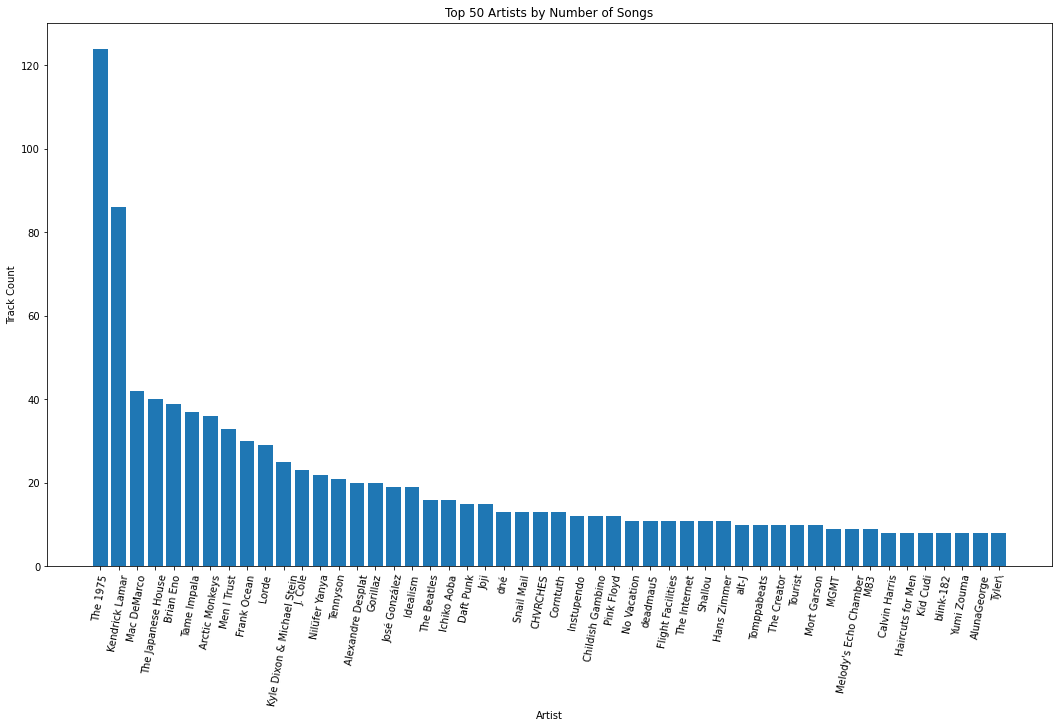

In [9]:
plt.figure(figsize=(18, 10))
plt.bar(artists['Artist'][:50], artists['Track Count'][:50])
plt.xticks(rotation=80)
plt.xlabel(artists.columns[0])
plt.ylabel(artists.columns[1])
plt.title('Top 50 Artists by Number of Songs')

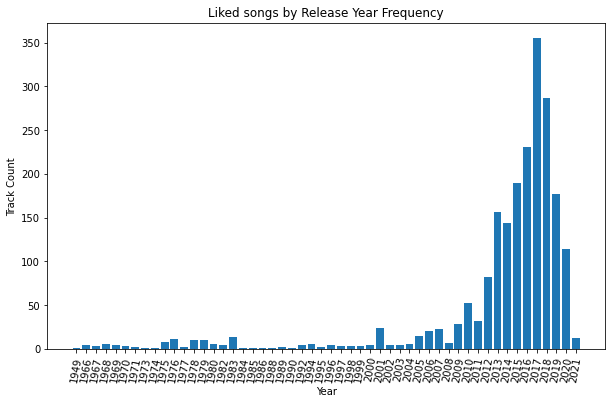

In [10]:
years = defaultdict(int)
for i,song in analysis_data.iterrows():
    years[song['Album Release Date'][:4]] += 1

years = pd.DataFrame(years.items(), columns=['Year', 'Track Count']).sort_values('Year')

plt.figure(figsize=(10, 6))
plt.bar(years['Year'], years['Track Count'])
plt.xticks(rotation=80)
plt.xlabel(years.columns[0])
plt.ylabel(years.columns[1])
plt.title('Liked songs by Release Year Frequency');

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


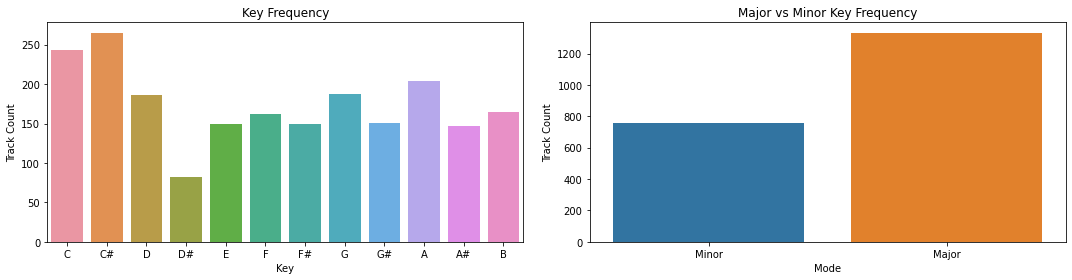

In [11]:
import seaborn as sns

plt.figure(figsize=(15,4))

plt.subplot(1, 2, 1)
axes = sns.countplot(analysis_data['Key'])
axes.set(xticklabels=['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B'])
plt.ylabel('Track Count')
plt.title('Key Frequency')

plt.subplot(1, 2, 2)
axes = sns.countplot(analysis_data['Mode'])
axes.set(xticklabels=['Minor', 'Major'])
plt.ylabel('Track Count')
plt.title('Major vs Minor Key Frequency');

plt.tight_layout(w_pad=2)

## Looking at the Bigger Picture


In [12]:
analysis_data = raw_data.copy()
analysis_data.groupby('Label').mean()

,Unnamed: 0,Disc Number,Track Number,Track Duration (ms),Explicit,Popularity,Added By,Danceability,Energy,Key,Loudness,Mode,Speechiness,Acousticness,Instrumentalness,Liveness,Valence,Tempo,Time Signature
Label,,,,,,,,,,,,,,,,,,,
False,2198.617060,1.040381,7.369328,236687.539927,0.164701,27.604809,NaN,0.559191,0.529814,5.263397,-10.538458,0.589464,0.114923,0.377752,0.351939,0.200036,0.391058,117.172566,3.883742
True,2093.646272,1.024379,5.667304,248234.139101,0.174952,36.484704,NaN,0.568123,0.536986,5.175992,-10.243712,0.637016,0.091516,0.371844,0.293425,0.185493,0.384280,118.639233,3.906265


From this we have some observations:
- The average popularity of songs that I like is more than those I do not like.
- On average I am liking more tracks that are in a Major key.
- I tend to like less speechy tracks.
- I prefer less instrumental tracks (not by too much). According to [Spotify's API reference](https://developer.spotify.com/documentation/web-api/reference/) this would indicate that on average my liked songs are containing more vocal content, which is interesting because if someone were to ask me this question I would probably respond with the opposite observation.

In [13]:
# ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']
analysis_data.groupby('Key').mean()

,Unnamed: 0,Disc Number,Track Number,Track Duration (ms),Explicit,Popularity,Added By,Danceability,Energy,Loudness,Mode,Speechiness,Acousticness,Instrumentalness,Liveness,Valence,Tempo,Time Signature,Label
Key,,,,,,,,,,,,,,,,,,,
0.0,2085.915152,1.038384,6.721212,221065.911111,0.137374,32.064646,NaN,0.548035,0.517326,-10.461842,0.789899,0.085621,0.398969,0.338569,0.185462,0.378276,118.144028,3.890909,0.490909
1.0,2147.745283,1.035849,6.307547,250480.715094,0.283019,31.049057,NaN,0.603719,0.558732,-9.750691,0.686792,0.131452,0.321296,0.301386,0.190895,0.392844,117.221072,3.949057,0.500000
2.0,2247.328395,1.039506,6.506173,231245.464198,0.123457,29.846914,NaN,0.533584,0.535737,-10.179793,0.782716,0.086269,0.374760,0.321024,0.194462,0.375006,116.695281,3.883951,0.459259
3.0,2125.042857,1.007143,6.385714,212895.457143,0.128571,32.821429,NaN,0.555042,0.431869,-12.807400,0.621429,0.092522,0.503701,0.413260,0.165076,0.352465,113.129664,3.864286,0.585714
4.0,2096.023490,1.026846,6.721477,242011.560403,0.140940,33.248322,NaN,0.541803,0.536351,-10.178040,0.489933,0.084041,0.392277,0.300525,0.207067,0.378469,119.907872,3.889262,0.500000
5.0,2136.562310,1.027356,6.519757,266010.182371,0.133739,31.413374,NaN,0.550513,0.536502,-10.515988,0.574468,0.094173,0.396759,0.330578,0.198621,0.396662,116.075881,3.893617,0.492401
6.0,2081.170492,1.013115,6.501639,249424.918033,0.134426,29.796721,NaN,0.566066,0.541556,-10.186374,0.452459,0.110742,0.363552,0.341945,0.199674,0.387511,119.213754,3.947541,0.491803
7.0,2222.311751,1.059952,6.568345,232041.546763,0.141487,34.621103,NaN,0.555553,0.536761,-10.542427,0.721823,0.103544,0.376695,0.328109,0.194372,0.395613,117.615417,3.844125,0.450839
8.0,2278.511327,1.029126,6.508091,232546.417476,0.165049,31.074434,NaN,0.577841,0.500842,-11.172091,0.656958,0.112780,0.397335,0.361743,0.188878,0.369049,115.625071,3.841424,0.488673


- Songs in C# are on average the most explicit? This is pretty interesting.
- The most popular songs have a key of G.

In [14]:
cmatrix = analysis_data.corr()
cmatrix["Label"].sort_values(ascending = False)

Label                  1.000000
Popularity             0.188764
Mode                   0.048790
Loudness               0.024206
Tempo                  0.024164
Danceability           0.024129
Time Signature         0.023851
Track Duration (ms)    0.019943
Energy                 0.014470
Explicit               0.013651
Acousticness          -0.008568
Key                   -0.012017
Valence               -0.013575
Disc Number           -0.024896
Unnamed: 0            -0.042307
Liveness              -0.044454
Instrumentalness      -0.076210
Speechiness           -0.095719
Track Number          -0.136299
Added By                    NaN
Name: Label, dtype: float64

From this correlation reading I'm inclined to believe that Track Number would be rather important in determing which songs I would like, but it's important to rmemeber there may be some bias here because single realeases would have a track number of 1 while tracks that reside within a full album will have a lot more variance.

Text(0, 0.5, 'Frequency of Occurance')

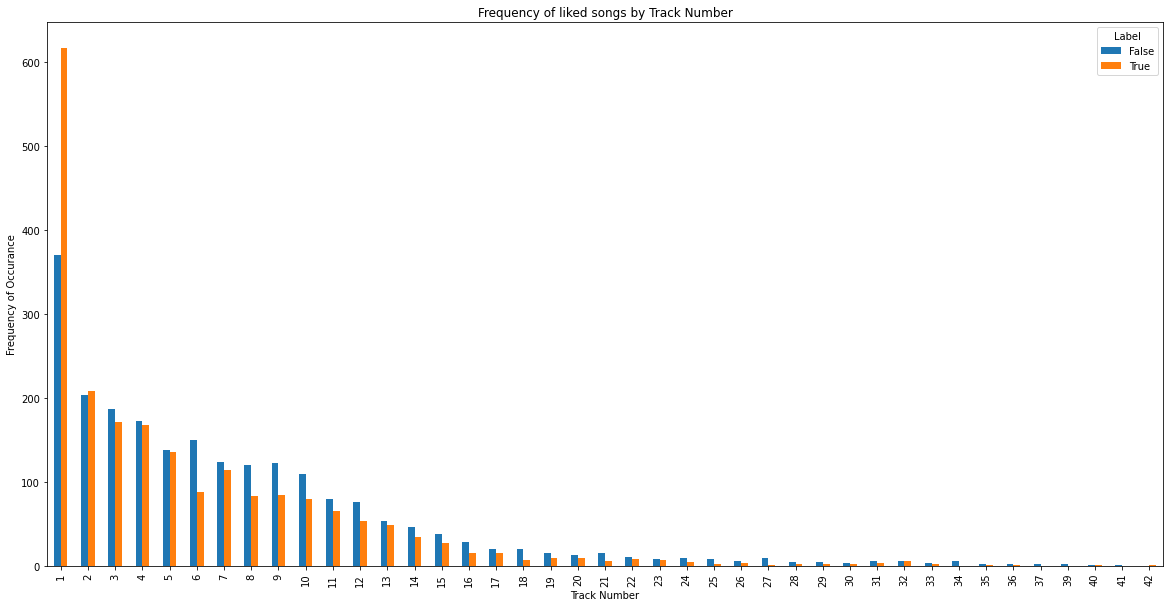

In [15]:
pd.crosstab(analysis_data['Track Number'], analysis_data.Label).plot(kind = 'bar', figsize = (20,10))
plt.title('Frequency of liked songs by Track Number')
plt.xlabel('Track Number')
plt.ylabel('Frequency of Occurance')

Sure enough we can see this imbalance indicating the presence of the bias I suspected. We will ditch this variable later on in the cleaning phase.

Text(0, 0.5, 'Frequency of Occurance')

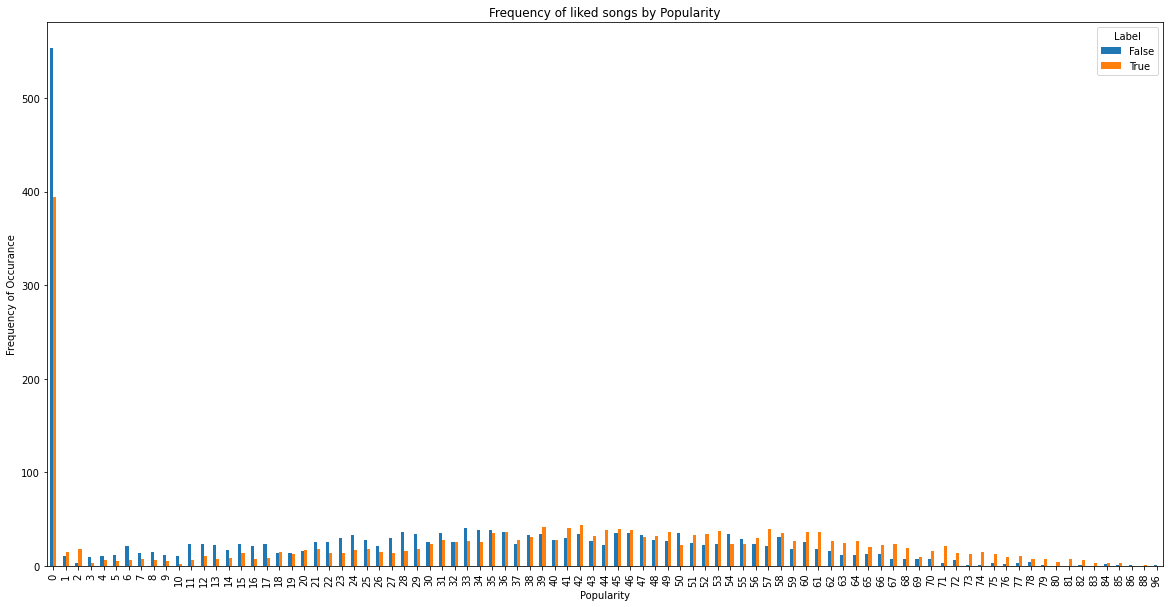

In [16]:
pd.crosstab(analysis_data['Popularity'].round(), analysis_data.Label).plot(kind = 'bar', figsize = (20,10))
plt.title('Frequency of liked songs by Popularity')
plt.xlabel('Popularity')
plt.ylabel('Frequency of Occurance')

Text(0, 0.5, 'Frequency of Occurance')

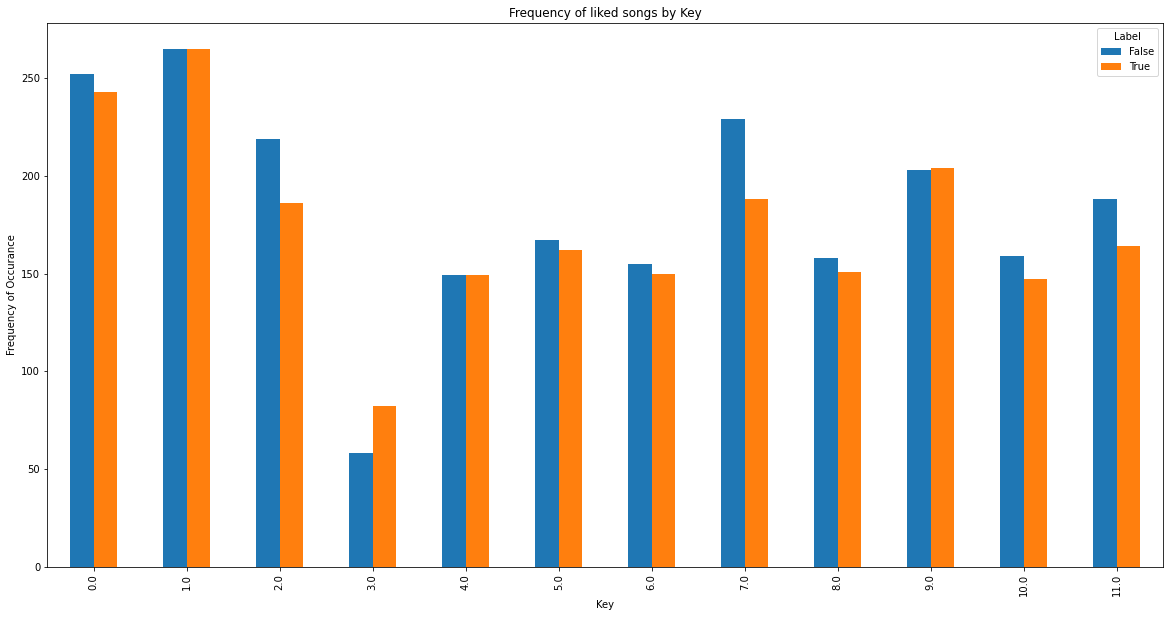

In [17]:
pd.crosstab(analysis_data['Key'], analysis_data.Label).plot(kind = 'bar', figsize = (20,10))
plt.title('Frequency of liked songs by Key')
plt.xlabel('Key')
plt.ylabel('Frequency of Occurance')

Nothing incredibly telling with popularity and key. We will keep these variables around. It also appears that there are no major imbalances present (at least in these variables).

# Data Cleaning

## Copying Set Over

In [18]:
processing_data = raw_data.copy()

# Features we are going to be training on
features = ['Explicit', 
            'Popularity', 
            'Danceability', 
            'Energy', 
            'Key', 
            'Loudness', 
            'Mode', 
            'Speechiness', 
            'Acousticness', 
            'Instrumentalness', 
            'Liveness', 
            'Valence', 
            'Tempo', 
            'Time Signature',
            'Label']
labels = ['Label']

processing_data = processing_data[features]

In [19]:
processing_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4296 entries, 0 to 4295
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Explicit          4296 non-null   bool   
 1   Popularity        4296 non-null   int64  
 2   Danceability      4293 non-null   float64
 3   Energy            4293 non-null   float64
 4   Key               4293 non-null   float64
 5   Loudness          4293 non-null   float64
 6   Mode              4293 non-null   float64
 7   Speechiness       4293 non-null   float64
 8   Acousticness      4293 non-null   float64
 9   Instrumentalness  4293 non-null   float64
 10  Liveness          4293 non-null   float64
 11  Valence           4293 non-null   float64
 12  Tempo             4293 non-null   float64
 13  Time Signature    4293 non-null   float64
 14  Label             4296 non-null   bool   
dtypes: bool(2), float64(12), int64(1)
memory usage: 444.8 KB


In [20]:
processing_data['Explicit'].value_counts()

False    3567
True      729
Name: Explicit, dtype: int64

In [21]:
processing_data['Key'].value_counts()

1.0     530
0.0     495
7.0     417
9.0     407
2.0     405
11.0    352
5.0     329
8.0     309
10.0    306
6.0     305
4.0     298
3.0     140
Name: Key, dtype: int64

In [22]:
processing_data['Mode'].value_counts()

1.0    2630
0.0    1663
Name: Mode, dtype: int64

In [23]:
# Checking for imbalance in the Labels (seems pretty good)
processing_data['Label'].value_counts(True)

False    0.513035
True     0.486965
Name: Label, dtype: float64

## Finding and Removing NaN Values

In [24]:
for col in processing_data.columns:
    print(col, ":", processing_data[col].isnull().sum())

Explicit : 0
Popularity : 0
Danceability : 3
Energy : 3
Key : 3
Loudness : 3
Mode : 3
Speechiness : 3
Acousticness : 3
Instrumentalness : 3
Liveness : 3
Valence : 3
Tempo : 3
Time Signature : 3
Label : 0


In [25]:
processing_data[processing_data['Danceability'].isna()]

,Explicit,Popularity,Danceability,Energy,Key,Loudness,Mode,Speechiness,Acousticness,Instrumentalness,Liveness,Valence,Tempo,Time Signature,Label
491,False,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
703,False,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2067,False,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False


In [26]:
# Drop rows that contain any null values
processing_data.dropna(inplace = True)

In [27]:
# Ensuring all features were fixed
for col in processing_data.columns:
    print(col, ":", processing_data[col].isnull().sum())

Explicit : 0
Popularity : 0
Danceability : 0
Energy : 0
Key : 0
Loudness : 0
Mode : 0
Speechiness : 0
Acousticness : 0
Instrumentalness : 0
Liveness : 0
Valence : 0
Tempo : 0
Time Signature : 0
Label : 0


In [28]:
# Replacing any NaN values with median
for col in processing_data.columns:
    if processing_data[col].isnull().sum() > 0 == True and processing_data[col].dtypes not in ['bool', 'category'] == True:
        processing_data[col] = processing_data[col].fillna(processing_data[col].median())

## Correlation Checking

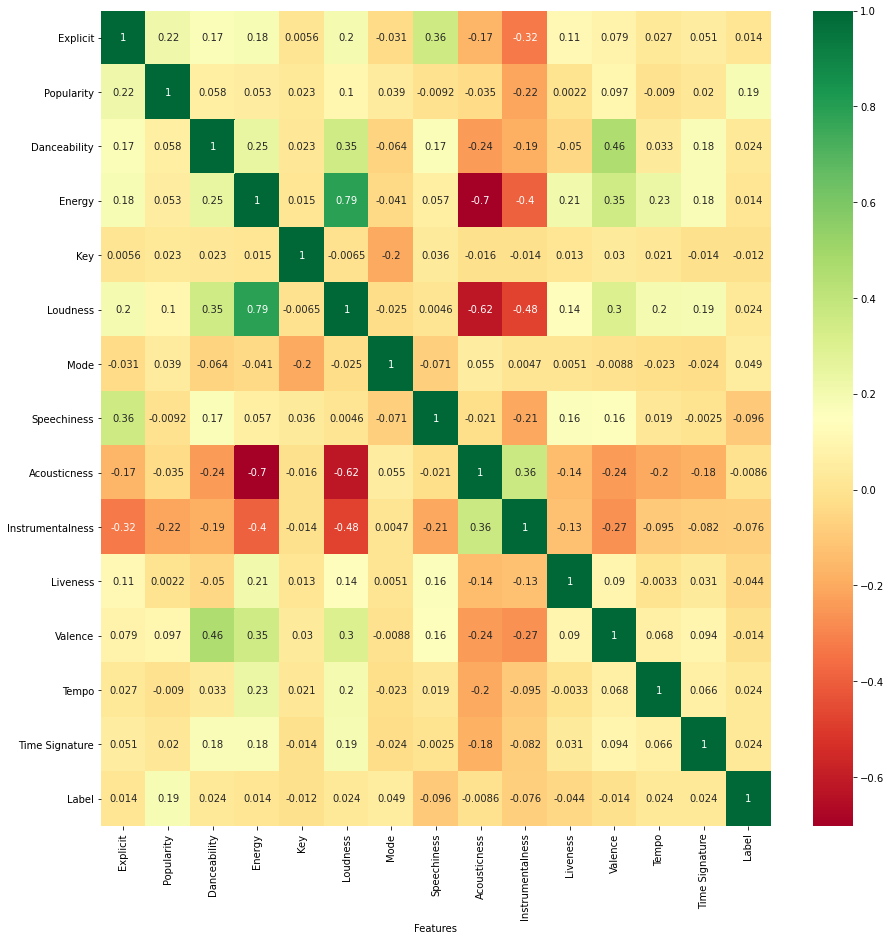

In [29]:
f,ax = plt.subplots(figsize = (15,15))
sns.heatmap(processing_data.corr(), annot = True, fmt = '.2g', cmap = 'RdYlGn', ax= ax)
sns.set(font_scale = 0.75)
plt.xlabel('Features')
plt.show()

In [30]:
cmatrix = processing_data.corr()
cmatrix["Label"].sort_values(ascending = False)

Label               1.000000
Popularity          0.188560
Mode                0.048790
Loudness            0.024206
Tempo               0.024164
Danceability        0.024129
Time Signature      0.023851
Energy              0.014470
Explicit            0.013560
Acousticness       -0.008568
Key                -0.012017
Valence            -0.013575
Liveness           -0.044454
Instrumentalness   -0.076210
Speechiness        -0.095719
Name: Label, dtype: float64

## Ordinal Encoding

In [31]:
def cutDown(df:pd.DataFrame, columns:list, bins:int):
  """Banding out the specified features within a data frame and recompiling them ordinally"""
  for col in columns:
    # Convert to float if its not a float
    if df[col].dtypes.name not in ['float64']:
      df[col] = df[col].astype("float64")

    # Cutting the column down
    df[col] = pd.cut(df[col], bins)

    # Pulling unique intervals
    intervals = df[col].unique().sort_values(ascending = True)
    df[col] = df[col].astype("object")

    # Ordinally encoding each interval in the column
    for interval in intervals:
      try:
        for x in range(0,bins):
          df[col].replace(intervals[x], int(x), inplace = True)
      except Exception as e:
        print(col + " has an empty bin, skipping...")

  return

In [32]:
# Variables that will be into 4 bins
group1 = ['Popularity', 'Danceability', 
           'Energy','Loudness', 
           'Speechiness', 'Acousticness', 
           'Instrumentalness', 'Liveness', 
           'Valence', 'Tempo', 
           'Time Signature']

In [33]:
cutDown(processing_data, columns = group1, bins = 4)

Time Signature has an empty bin, skipping...
Time Signature has an empty bin, skipping...
Time Signature has an empty bin, skipping...


In [34]:
processing_data['Time Signature'].value_counts()

2    3873
1     360
0      60
Name: Time Signature, dtype: int64

Great, there is no data loss for the Time Signature feature, now we can move on to key and mode cutting and encoding.

In [35]:
# Key and Mode cut down
cutDown(processing_data, columns = ['Key'], bins = 12)
cutDown(processing_data, columns = ['Mode'], bins = 2)

In [36]:
cutDown(processing_data, columns = ['Explicit', 'Label'], bins = 2)

In [37]:
processing_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4293 entries, 0 to 4295
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   Explicit          4293 non-null   int64
 1   Popularity        4293 non-null   int64
 2   Danceability      4293 non-null   int64
 3   Energy            4293 non-null   int64
 4   Key               4293 non-null   int64
 5   Loudness          4293 non-null   int64
 6   Mode              4293 non-null   int64
 7   Speechiness       4293 non-null   int64
 8   Acousticness      4293 non-null   int64
 9   Instrumentalness  4293 non-null   int64
 10  Liveness          4293 non-null   int64
 11  Valence           4293 non-null   int64
 12  Tempo             4293 non-null   int64
 13  Time Signature    4293 non-null   int64
 14  Label             4293 non-null   int64
dtypes: int64(15)
memory usage: 536.6 KB


In [38]:
processing_data.head(5)

,Explicit,Popularity,Danceability,Energy,Key,Loudness,Mode,Speechiness,Acousticness,Instrumentalness,Liveness,Valence,Tempo,Time Signature,Label
0,0,1,2,2,2,3,1,0,1,0,1,2,1,2,0
1,1,2,1,2,5,3,0,2,0,0,1,1,1,2,0
2,0,2,0,3,4,3,0,0,0,0,0,0,3,1,0
3,0,2,1,3,8,3,1,0,0,0,0,2,3,2,1
4,0,1,2,3,11,3,0,0,0,0,1,3,1,2,0


# Data Set Splitting

In [39]:
from sklearn.model_selection import train_test_split

ds_features = processing_data[features[:-1]]
ds_labels = processing_data['Label']

train_X, validation_X, train_Y, validation_Y  = train_test_split(ds_features, 
                                                                 ds_labels,
                                                                 test_size = 0.20)

In [40]:
from imblearn.over_sampling import SMOTE

samp = SMOTE(random_state = 0)

columns = train_X.columns

os_data_X, os_data_Y = samp.fit_sample(train_X, train_Y)

os_data_X = pd.DataFrame(data = os_data_X, columns = columns)
os_data_Y = pd.DataFrame(data = os_data_Y, columns = ['Label'])

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [41]:
# Nomalization of testing and training sets
train_X -= train_X.mean(axis = 0)
train_X /= train_X.std(axis = 0)

validation_X -= validation_X.mean(axis = 0)
validation_X /= validation_X.std(axis = 0)

The below function compiles all of the stats we will use to evaluate our model. Our model's goal is to prioritize maximizing the number of true positive values as this is reflective of how we will be using the model.

A model that has many false positives is what we will want to avoid. Vieing these metrics in a confusion matrix will make the evaluation process a lot simpler to understand.

In [42]:
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

def evaluateModel(model, valid_X, valid_Y, model_label:str, format:str):
  """Provides statistics and a confusion matrix visualization of a particular model."""

  if format not in ['percent','count', 'p', 'c']:
    raise ValueError(format + " is not a supported option.")

  sns.set(font_scale = 1.5)

  predictions = model.predict(valid_X)

  while True:
    try:
      print("Accuracy:", round(accuracy_score(valid_Y, predictions), 3))
      print("Precision:", round(precision_score(valid_Y, predictions), 3))
      print("Recall Score:", round(recall_score(valid_Y, predictions), 3))
      print("F1 Score:", round(f1_score(valid_Y, predictions), 3))
    except ValueError:
      predictions = model.predict(valid_X).round()
      continue
    break

  conf_mat = confusion_matrix(valid_Y, predictions)
  labels = [0,1]
  fig, ax = plt.subplots(figsize = (10,10))
  ticks = np.arange(len(labels))

  plt.xticks(ticks, labels)
  plt.yticks(ticks, labels)
  
  if format == 'c' or format == 'count':
    sns.heatmap(pd.DataFrame(conf_mat), 
                annot=True, 
                cmap="flare", 
                fmt='g')
  if format == 'p' or format == 'percent':
    sns.heatmap(pd.DataFrame(conf_mat)/np.sum(conf_mat), 
                annot=True, 
                cmap="flare", 
                fmt='.1%')

  ax.xaxis.set_label_position("bottom")
  plt.title(model_label + " Confusion Matrix", y=1.1)
  plt.ylabel('True Label')
  plt.xlabel('Predicted Label')

# Logistic Regression Approach

## Prep

In [43]:
# Converting Trues and Falses into 0 or 1
processing_data['Label'] = processing_data['Label'].astype('float64')

## Recursive Feature Elimination

In [44]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

l_reg = LogisticRegression()

selection = RFE(l_reg, 50)
selection = selection.fit(os_data_X, os_data_Y.values.ravel())
print(selection.support_)
print(selection.ranking_)

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1]


## Training

Looks like we will be using all of the variables I trimmed down to, nice.

In [45]:
l_reg.fit(os_data_X, os_data_Y)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

## Results

In [46]:
l_reg.score(validation_X, validation_Y) * 100

58.44004656577415

Accuracy: 0.584
Precision: 0.655
Recall Score: 0.313
F1 Score: 0.423


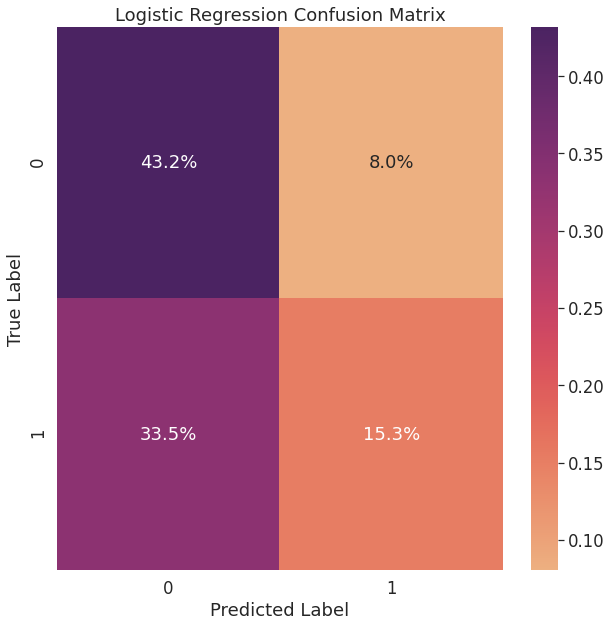

In [47]:
evaluateModel(l_reg, 
              validation_X, 
              validation_Y, 
              model_label = "Logistic Regression", 
              format = 'percent')

Our results are very sub-optimal because we are seeing 33.5% of our predictions as false negatives. Ideally we want to minimize false negatives and maximize true positives as this is how we will be using the model to construct better playlists.

# Decision Tree Classification Approach

## Classifier Training

In [48]:
from sklearn.tree import DecisionTreeClassifier


dt_model = DecisionTreeClassifier(max_depth = 5)
dt_model.fit(train_X, train_Y)

dt_model.score(validation_X, validation_Y)*100

59.60419091967404

## Classifier Results

Accuracy: 0.596
Precision: 0.61
Recall Score: 0.475
F1 Score: 0.534


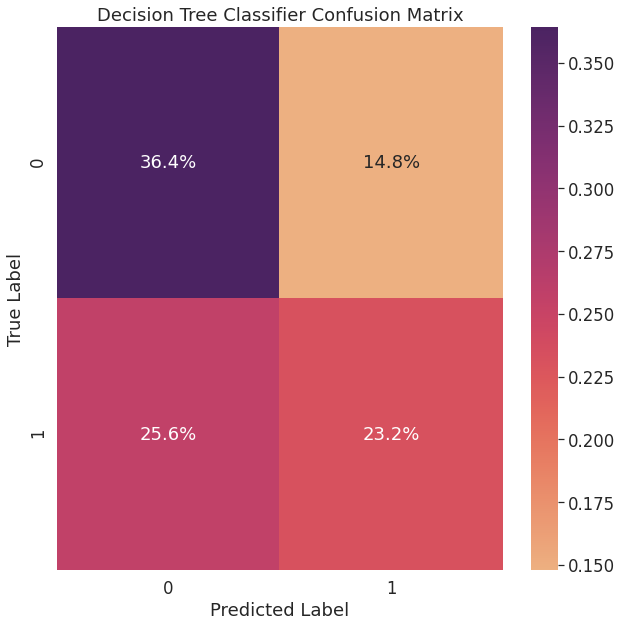

In [49]:
evaluateModel(dt_model, 
              validation_X, 
              validation_Y, 
              model_label = "Decision Tree Classifier",
              format = "percent")

# Random Forest Approach

## Random Forest Classifier Training

In [50]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(criterion = 'entropy', max_depth = 5, n_estimators = 100)
rf_model.fit(train_X, train_Y)

rf_model.score(validation_X, validation_Y) * 100

58.905704307334105

## Random Forest Classifier Results

Accuracy: 0.589
Precision: 0.596
Recall Score: 0.487
F1 Score: 0.536


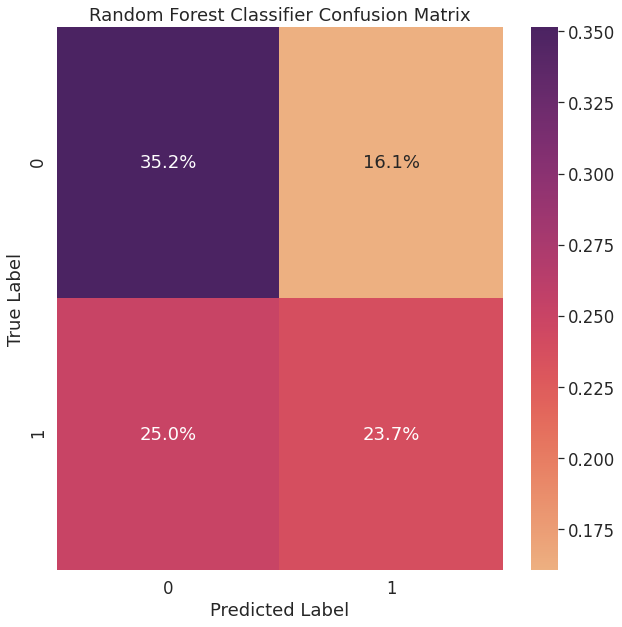

In [51]:
evaluateModel(rf_model, 
              validation_X, 
              validation_Y, 
              model_label = "Random Forest Classifier",
              format = "percent")

# Neural Network Data Prep
In order to this we must tranform the labels into their 0 and 1 counterparts to fit the Binary classification specifications.

In [52]:
# Copy of the training sets and conversion 
nn_train_X = train_X.copy()
nn_validation_X = validation_X.copy()

nn_train_Y = train_Y.copy()
# nn_train_Y[nn_train_Y[:] == True] = 1.0

nn_validation_Y = validation_Y.copy()
# nn_validation_Y[nn_validation_Y[:] == True] = 1.0

In [53]:
# Ordinal encoding for categorical variables
for col in nn_train_X.columns:
    if nn_train_X[col].dtypes.name == 'category' or nn_train_X[col].dtypes.name == 'int64':
        nn_train_X[col] = nn_train_X[col].astype("float64")

for col in nn_validation_X.columns:
    if nn_validation_X[col].dtypes.name == 'category' or nn_validation_X[col].dtypes.name == 'int64':
        nn_validation_X[col] = nn_validation_X[col].astype("float64")

In [54]:
nn_validation_X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 859 entries, 3952 to 3764
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Explicit          859 non-null    float64
 1   Popularity        859 non-null    float64
 2   Danceability      859 non-null    float64
 3   Energy            859 non-null    float64
 4   Key               859 non-null    float64
 5   Loudness          859 non-null    float64
 6   Mode              859 non-null    float64
 7   Speechiness       859 non-null    float64
 8   Acousticness      859 non-null    float64
 9   Instrumentalness  859 non-null    float64
 10  Liveness          859 non-null    float64
 11  Valence           859 non-null    float64
 12  Tempo             859 non-null    float64
 13  Time Signature    859 non-null    float64
dtypes: float64(14)
memory usage: 100.7 KB


In [55]:
nn_validation_X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 859 entries, 3952 to 3764
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Explicit          859 non-null    float64
 1   Popularity        859 non-null    float64
 2   Danceability      859 non-null    float64
 3   Energy            859 non-null    float64
 4   Key               859 non-null    float64
 5   Loudness          859 non-null    float64
 6   Mode              859 non-null    float64
 7   Speechiness       859 non-null    float64
 8   Acousticness      859 non-null    float64
 9   Instrumentalness  859 non-null    float64
 10  Liveness          859 non-null    float64
 11  Valence           859 non-null    float64
 12  Tempo             859 non-null    float64
 13  Time Signature    859 non-null    float64
dtypes: float64(14)
memory usage: 100.7 KB


# Binary Classification Neural Network Approach

## BCNN Definition

In [56]:
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential

nn_model = Sequential()
nn_model.add(Dense(8, input_dim = len(ds_features.columns), activation = 'relu'))
nn_model.add(Dense(4, activation = 'relu'))
nn_model.add(Dense(2, activation = 'relu'))
nn_model.add(Dense(1, activation = 'sigmoid'))

nn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 120       
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 36        
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 10        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 3         
Total params: 169
Trainable params: 169
Non-trainable params: 0
_________________________________________________________________


## BCNN Training

In [57]:
# Checking devices available
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [58]:
# Training model
with tf.device('/GPU:0'):
    nn_model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
    nn_model.fit(nn_train_X, nn_train_Y, epochs = 100, verbose = True, validation_data = (nn_validation_X, nn_validation_Y))

Epoch 1/100
108/108 [==============================] - 2s 4ms/step - loss: 0.6968 - accuracy: 0.5137 - val_loss: 0.6981 - val_accuracy: 0.5064
Epoch 2/100
108/108 [==============================] - 0s 3ms/step - loss: 0.6889 - accuracy: 0.5387 - val_loss: 0.6960 - val_accuracy: 0.5262
Epoch 3/100
108/108 [==============================] - 0s 3ms/step - loss: 0.6848 - accuracy: 0.5492 - val_loss: 0.6939 - val_accuracy: 0.5448
Epoch 4/100
108/108 [==============================] - 0s 3ms/step - loss: 0.6815 - accuracy: 0.5591 - val_loss: 0.6905 - val_accuracy: 0.5471
Epoch 5/100
108/108 [==============================] - 0s 3ms/step - loss: 0.6788 - accuracy: 0.5629 - val_loss: 0.6888 - val_accuracy: 0.5658
Epoch 6/100
108/108 [==============================] - 0s 3ms/step - loss: 0.6763 - accuracy: 0.5728 - val_loss: 0.6870 - val_accuracy: 0.5681
Epoch 7/100
108/108 [==============================] - 0s 3ms/step - loss: 0.6739 - accuracy: 0.5821 - val_loss: 0.6859 - val_accuracy: 0.5704

## BCNN Results

Accuracy: 0.582
Precision: 0.576
Recall Score: 0.544
F1 Score: 0.56


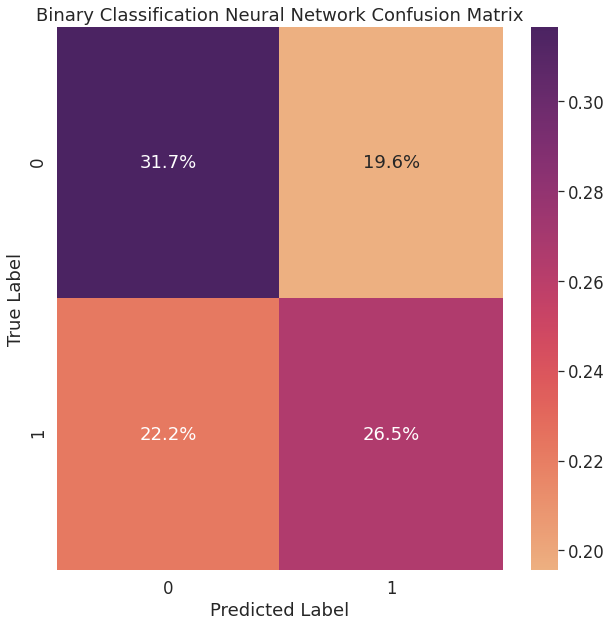

In [59]:
evaluateModel(nn_model, 
              nn_validation_X, 
              nn_validation_Y,
              "Binary Classification Neural Network",
              format = "percent")

It is clear that this model is performing much better than the previous ones as we have far less false positives and good performance on true positives and true negatives.

# Convolutional Neural Network Approach (SuperTML)
Following concepts from this paper here: https://arxiv.org/abs/1903.06246

## Data Prep

In [62]:
# Copying datasets over to be manipulated
cnn_train_X = nn_train_X.copy()
cnn_train_Y = nn_train_Y.copy()

cnn_valid_X = nn_validation_X.copy()
cnn_valid_Y = nn_validation_Y.copy()

## Transforming Features Into Images

In [63]:
!fc-list

/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Italic.ttf: Liberation Sans Narrow:style=Italic
/usr/share/fonts/truetype/liberation/LiberationSans-Regular.ttf: Liberation Sans:style=Regular
/usr/share/fonts/truetype/liberation/LiberationMono-BoldItalic.ttf: Liberation Mono:style=Bold Italic
/usr/share/fonts/truetype/liberation/LiberationSerif-Italic.ttf: Liberation Serif:style=Italic
/usr/share/fonts/truetype/liberation/LiberationMono-Bold.ttf: Liberation Mono:style=Bold
/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Regular.ttf: Liberation Sans Narrow:style=Regular
/usr/share/fonts/truetype/liberation/LiberationSerif-Bold.ttf: Liberation Serif:style=Bold
/usr/share/fonts/truetype/liberation/LiberationMono-Regular.ttf: Liberation Mono:style=Regular
/usr/share/fonts/truetype/liberation/LiberationSans-Italic.ttf: Liberation Sans:style=Italic
/usr/share/fonts/truetype/liberation/LiberationSerif-BoldItalic.ttf: Liberation Serif:style=Bold Italic
/usr/share/fonts/truet

A large portion of the following conversion algorithm is based on [EmjayAhn's implementation of feature creation.](https://github.com/EmjayAhn/SuperTML-pytorch/blob/c962956fe80112ec9cae9086fca296b52c67718a/data_preparation.py#L28)

My algorithm differs in the number of parameters it is converting, its final format (channels last), and that it is taking a Pandas data frame as input.

In [64]:
# can likely improve this by not constructing a dataset in memory

from PIL import Image, ImageDraw, ImageFont
import pandas as pd

def imageEncode(data):
    images = []
    font = ImageFont.truetype("LiberationMono-Regular.ttf", size = 25)
    location = [(25, 20), (100, 20), (175, 20), 
                (25, 70), (100, 70), (175, 70), 
                (25, 120), (100, 120), (175, 120), 
                (25, 170), (100, 170),(175, 170),
                (50, 215), (150, 215)]
    

    # Going through each row
    for row in data.iterrows():
        # Generate base image
        bg = np.array([[0 for _ in range(255)] for _ in range(255)], dtype = 'uint8')
        image = Image.fromarray(bg)
        draw = ImageDraw.Draw(image)

        # Adding each feature to the image
        l = 0
        for col in range(0, len(data.columns)):
          value = round(row[1][col], 2)
#           if value < -0.50:
#             draw.text(location[l], str(value), fill = '#333399', font = font)
#           elif value > -0.50 and value < 0.0:
#             draw.text(location[l], str(value), fill = '#3366cc', font = font)
#           elif value == 0.0:
#             draw.text(location[l], str(value), fill = 'white', font = font)
#           elif value > 0.0 and value < 0.50:
#             draw.text(location[l], str(value), fill = '#cc6600', font = font)
#           elif value > 0.50:
#             draw.text(location[l], str(value), fill = '#cc3300', font = font)
          
          draw.text(location[l], str(value), fill = 'white', font = font)
          l += 1
        
        rgb = [np.array(image, dtype='uint8') for _ in range(3)]
        images.append(rgb)

    images = np.array(images) / 255

    # move to channels last format
    images = np.moveaxis(images, 1, -1)

    return images

In [65]:
temp_set = imageEncode(cnn_train_X.sample(1))

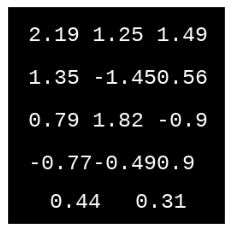

In [66]:
plt.figure()
plt.xticks([])
plt.yticks([])
plt.grid(False)
plt.imshow(temp_set[0])

In [67]:
cnn_train_X = imageEncode(cnn_train_X)
cnn_valid_X = imageEncode(cnn_valid_X)

In [68]:
print(cnn_train_X.shape)
print(cnn_valid_X.shape)

(3434, 255, 255, 3)
(859, 255, 255, 3)


## Network Definition

In [69]:
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dropout, Flatten, Conv2D, MaxPooling2D, Dense, Activation
    
cnn_model = Sequential()
cnn_model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(255, 255, 3)))
cnn_model.add(MaxPooling2D((2, 2)))
cnn_model.add(Conv2D(64, (3, 3), activation='relu'))
cnn_model.add(MaxPooling2D((2, 2)))
cnn_model.add(Conv2D(64, (3, 3), activation='relu'))

cnn_model.add(Flatten())
cnn_model.add(Dense(64, activation='relu'))
cnn_model.add(Dense(10))
cnn_model.add(Dense(1, activation = 'sigmoid'))

cnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 253, 253, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 126, 126, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 124, 124, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 64)        36928     
_________________________________________________________________
flatten (Flatten)            (None, 230400)            0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)               

## Network Training

In [70]:
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001)

with tf.device('/GPU:0'):
    cnn_model.compile(loss = 'binary_crossentropy', optimizer = optimizer, metrics = ['accuracy'])
    cnn_model.fit(cnn_train_X, cnn_train_Y, epochs = 100, verbose = True, validation_data = (cnn_valid_X, cnn_valid_Y))

Epoch 1/100
108/108 [==============================] - 18s 34ms/step - loss: 0.6919 - accuracy: 0.5416 - val_loss: 0.6894 - val_accuracy: 0.5134
Epoch 2/100
108/108 [==============================] - 3s 26ms/step - loss: 0.6787 - accuracy: 0.5766 - val_loss: 0.6803 - val_accuracy: 0.5867
Epoch 3/100
108/108 [==============================] - 3s 26ms/step - loss: 0.6731 - accuracy: 0.5868 - val_loss: 0.6781 - val_accuracy: 0.5576
Epoch 4/100
108/108 [==============================] - 3s 26ms/step - loss: 0.6697 - accuracy: 0.5900 - val_loss: 0.6804 - val_accuracy: 0.5588
Epoch 5/100
108/108 [==============================] - 3s 26ms/step - loss: 0.6708 - accuracy: 0.5842 - val_loss: 0.6810 - val_accuracy: 0.5541
Epoch 6/100
108/108 [==============================] - 3s 26ms/step - loss: 0.6681 - accuracy: 0.5871 - val_loss: 0.6763 - val_accuracy: 0.5891
Epoch 7/100
108/108 [==============================] - 3s 26ms/step - loss: 0.6665 - accuracy: 0.5815 - val_loss: 0.6763 - val_accuracy

## SuperTML Evaluation

Accuracy: 0.549
Precision: 0.569
Recall Score: 0.315
F1 Score: 0.406


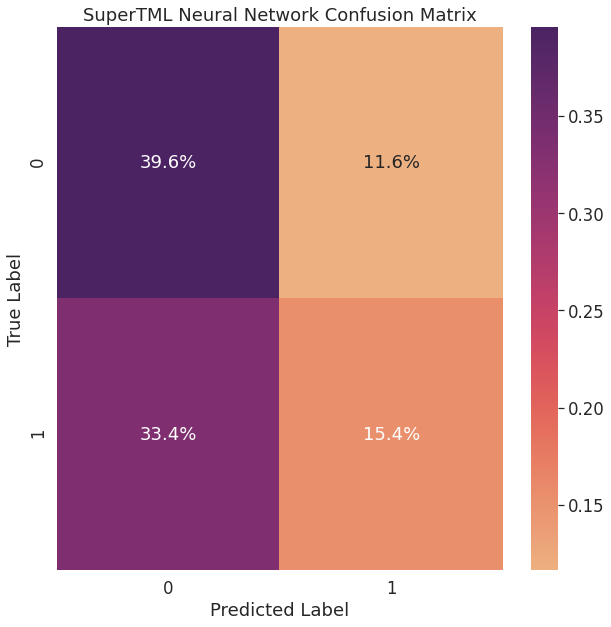

In [71]:
evaluateModel(cnn_model, 
              cnn_valid_X, 
              cnn_valid_Y,
              model_label = "SuperTML Neural Network",
              format = "percent")

This is by far our worst performing model on this testing data. There are an overwhelming amount of false negatives and a minimal amount of true positives. Ouch.